In [2]:
import os
os.chdir('/Users/167011/Documents/MQF/Thesis/repo/')

import numpy as np
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import torch
import matplotlib.pyplot as plt

# Read in raw parquet
table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")

# table = pq.read_table("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")


# Convert to pandas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define maturity in years 'tau'
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['tau'] = (df['expiry'] - reference_date).dt.days / 365.25 # Crypto is traded 24/7

# Filter for just calls and open_interest > 0 
df = df[(df['option_type'] == 'C') & (df['open_interest'] > 0)]

# Define mid price
df['mid_price'] = (df['best_bid_price'] + df['best_ask_price']) / 2

# Convert strike to numeric
df['strike'] = pd.to_numeric(df['strike'], errors = 'coerce')

# Define log moneyness, 'm'
df['m'] = np.log(df['strike'] / df['underlying_price'])

# # Choose tau grid based on Kmeans clustering

unique_taus = np.sort(df['tau'].unique()).reshape(-1,1)
# Finding different clusters of tau  (time to expiry)
tau_kmeans = KMeans(n_clusters=7, random_state=0).fit(unique_taus)
# Get the cluster centers and sort them
tau_grid = np.sort(tau_kmeans.cluster_centers_.flatten())
# Assign each quote to a cluster
df['tau_cluster'] = tau_kmeans.predict(df[['tau']])

# Moneyness grid for each tau (ttm)
m_grid = {}
for cluster_label, tau in enumerate(tau_grid):
    # Select all rows in that clust
    subset = df[df['tau_cluster'] == cluster_label]
    # Get min and max m for that cluster
    m_lo, m_hi = np.percentile(subset['m'], [1, 99])
    m_grid[tau] = np.linspace(m_lo, m_hi, 10) # here we are assuming each moneyness point is equally likely

print(tau_grid)

for τi in tau_grid:
    print(f"τ={τi:.4f} → m_grid={m_grid[τi]}")


# Building the list of all (tau_i, m_ij) nodes
nodes = []
for tau in tau_grid:
    for m_j in m_grid[tau]:
        nodes.append((tau, m_j))
nodes = np.array(nodes) # Shape (N_nodes, 2)

# Fit to nearest neighbor model on those nodes
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(nodes)

# Query eachquote's (tau, m) to find the nearest node
points = df[['tau', 'm']].values # Shape (N_quotes, 2)
distances, indices = nn.kneighbors(points)



# Store back into dataframe
df['node_idx'] = indices[:, 0] # which row of 'nodes' it snapped too
df['lattice_tau']   = nodes[df['node_idx'], 0] # which tau it snapped too
df['lattice_m']     = nodes[df['node_idx'], 1] # which m it snapped too

# Within each time-slice, pick the most liquid quote per node:
best = (
    df
    .sort_values('open_interest', ascending = False)
    .drop_duplicates(subset = ['timestamp', 'node_idx'])
    .reset_index(drop = True)
)

best = best[['timestamp', 'node_idx', 'lattice_tau', 'lattice_m', 'mid_price']]

# Pivot to get a sparse lattice DataFrame (NaNs left in place)
C_sparse = best.pivot(
    index = 'timestamp',
    columns = 'node_idx',
    values = 'mid_price'
)

# Mask zeros as NaN so interpolation will fill them
C_sparse = C_sparse.replace(0, np.nan)

# Interpolate in time, then forward- and back-fill any edge NaNs
C_interp = (
    C_sparse
    .interpolate(method='linear', axis=0)  # linear interpolation along timestamps
    .ffill()                              # carry last valid forward
    .bfill()                              # fill any leading NaNs at the start
)


/var/folders/7p/px6mp0t52794gwq4s0r9jst0ytvmtk/T/ipykernel_30248/302307346.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


[0.00752909 0.04106776 0.07939767 0.15605749 0.40520192 0.65434634
 0.90349076]
τ=0.0075 → m_grid=[-1.25368823 -1.04272745 -0.83176668 -0.62080591 -0.40984514 -0.19888437
  0.0120764   0.22303717  0.43399795  0.64495872]
τ=0.0411 → m_grid=[-1.75333077 -1.42006121 -1.08679164 -0.75352208 -0.42025252 -0.08698296
  0.24628661  0.57955617  0.91282573  1.2460953 ]
τ=0.0794 → m_grid=[-1.69696503 -1.36384192 -1.03071881 -0.69759569 -0.36447258 -0.03134947
  0.30177365  0.63489676  0.96801987  1.30114299]
τ=0.1561 → m_grid=[-1.7256284  -1.39235929 -1.05909018 -0.72582107 -0.39255196 -0.05928285
  0.27398627  0.60725538  0.94052449  1.2737936 ]
τ=0.4052 → m_grid=[-1.24483937 -1.04572634 -0.84661331 -0.64750028 -0.44838725 -0.24927422
 -0.05016119  0.14895184  0.34806487  0.5471779 ]
τ=0.6543 → m_grid=[-1.66826934 -1.36728337 -1.0662974  -0.76531143 -0.46432547 -0.1633395
  0.13764647  0.43863244  0.73961841  1.04060438]
τ=0.9035 → m_grid=[-0.15133658 -0.09411936 -0.03690213  0.02031509  0.07753

In [4]:
print(C_interp)

node_idx                      0      1      2        3         4         5   \
timestamp                                                                     
2025-01-30 00:00:58.943  0.71125  0.615  0.567  0.46100  0.335750  0.229750   
2025-01-30 00:00:59.032  0.71125  0.615  0.567  0.46100  0.335750  0.229750   
2025-01-30 00:00:59.950  0.71125  0.615  0.567  0.46100  0.335750  0.229750   
2025-01-30 00:01:00.957  0.71125  0.615  0.567  0.46100  0.335750  0.229750   
2025-01-30 00:01:01.974  0.71125  0.615  0.567  0.46100  0.335750  0.229750   
...                          ...    ...    ...      ...       ...       ...   
2025-01-30 02:11:01.841  0.71200  0.616  0.568  0.46172  0.326435  0.230449   
2025-01-30 02:11:02.849  0.71200  0.616  0.568  0.46250  0.327092  0.230882   
2025-01-30 02:11:03.855  0.71200  0.616  0.568  0.40475  0.327750  0.231316   
2025-01-30 02:11:04.862  0.71200  0.616  0.568  0.40475  0.279750  0.231750   
2025-01-30 02:11:05.870  0.71200  0.616  0.568  0.40

In [10]:

# We now extract the timesteps between observed option snapshot
timestamps = C_interp.index.to_series()

# Compute raw delta t in seconds (or fractions of a second) between each row
dt_secs = timestamps.diff().dt.total_seconds().to_numpy()

print(dt_secs)

[  nan 0.089 0.918 ... 1.006 1.007 1.008]


In [5]:
node_map = pd.DataFrame(
    nodes,
    columns=["tau", "m"],
    index=pd.Index(range(len(nodes)), name="node_idx")
)

print(node_map)

               tau         m
node_idx                    
0         0.007529 -1.253688
1         0.007529 -1.042727
2         0.007529 -0.831767
3         0.007529 -0.620806
4         0.007529 -0.409845
...            ...       ...
65        0.903491  0.134750
66        0.903491  0.191967
67        0.903491  0.249184
68        0.903491  0.306401
69        0.903491  0.363618

[70 rows x 2 columns]


Epoch 1/100  Train NLL: -3.6946e+00  Test NLL: -4.2918e+00
Epoch 2/100  Train NLL: -4.2791e+00  Test NLL: -4.0175e+00
Epoch 3/100  Train NLL: -4.3442e+00  Test NLL: -4.0556e+00
Epoch 4/100  Train NLL: -4.3400e+00  Test NLL: -4.5062e+00
Epoch 5/100  Train NLL: -4.3578e+00  Test NLL: -3.6193e+00
Epoch 6/100  Train NLL: -4.4296e+00  Test NLL: -4.5275e+00
Epoch 7/100  Train NLL: -4.6204e+00  Test NLL: -4.6721e+00
Epoch 8/100  Train NLL: -4.2102e+00  Test NLL: -3.7722e+00
Epoch 9/100  Train NLL: -4.4694e+00  Test NLL: -4.7587e+00
Epoch 10/100  Train NLL: -4.7267e+00  Test NLL: -4.8656e+00
Epoch 11/100  Train NLL: -4.7173e+00  Test NLL: -4.7723e+00
Epoch 12/100  Train NLL: -4.7200e+00  Test NLL: -4.8737e+00
Epoch 13/100  Train NLL: -4.8349e+00  Test NLL: -4.1731e+00
Epoch 14/100  Train NLL: -4.7937e+00  Test NLL: -4.7171e+00
Epoch 15/100  Train NLL: -4.8498e+00  Test NLL: -4.7892e+00
Epoch 16/100  Train NLL: -4.8410e+00  Test NLL: -4.6717e+00
Epoch 17/100  Train NLL: -4.8865e+00  Test NLL: -

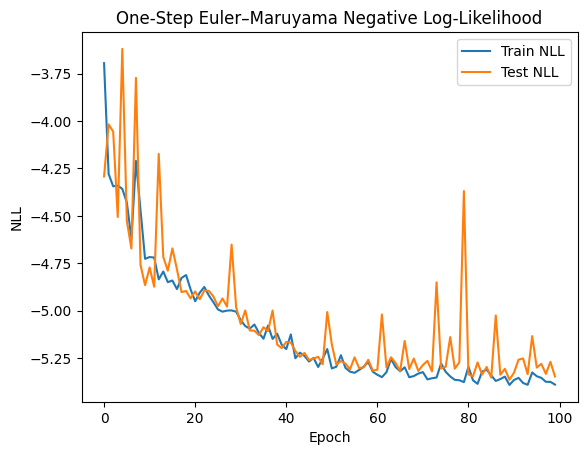

In [13]:
surf_arr = C_interp.to_numpy()              # or C.values
# print(surf_arr)
surf_tensor = torch.from_numpy(surf_arr).float()
import torch
import torch.nn as nn
import torch.optim as optim
import torchsde
import numpy as np
import math
import matplotlib.pyplot as plt

# 1) Load the BTC surface tensor
surf = surf_tensor  # shape [T, N]
T, N = surf.shape

# Load dt tensor
dt_tensor = torch.load('dt.pt')

# 2) Train/Test split (80/20)
split = int(T * 0.8)
surf_train = surf[:split]
surf_test = surf[split:]

device = "cuda" if torch.cuda.is_available() else "cpu"
surf_train = surf_train.to(device)
surf_test = surf_test.to(device)

# align dt
dt_train = dt_tensor[:split].to(device)
dt_test = dt_tensor[split:].to(device)

# Define dt pairs for each surface
dt_train_pairs = dt_train[1:].view(-1, 1)
dt_test_pairs = dt_test[1:].view(-1, 1)


# 3) Define the neural SDE on R^N
class SurfaceSDE(torchsde.SDEIto):
    def __init__(self, dim):
        super().__init__(noise_type="diagonal")
        # Drift network
        self.f_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
        # Diffusion network (output ≥ 0)
        self.g_net = nn.Sequential(
            nn.Linear(dim, 128),
            nn.ReLU(),
            nn.Linear(128, dim),
            nn.Softplus()
        )

    def f(self, t, y):
        return self.f_net(y)

    def g(self, t, y):
        return self.g_net(y)

model = SurfaceSDE(N).to(device)

# 4) Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 100
batch_size = 32


train_losses = []
test_losses = []

# 5) Training loop with likelihood-based loss
for epoch in range(n_epochs):
    model.train()
    perm = torch.randperm(split - 1)
    epoch_loss = 0.0

    for idx in perm.split(batch_size):
        y0 = surf_train[idx]       # [batch_size, N]
        y1 = surf_train[idx + 1]   # next step
        # Compute drift and diffusion
        drift = model.f(0, y0)     # [batch_size, N]
        diff = model.g(0, y0)      # [batch_size, N]
        # Compute increments
        dy = y1 - y0
        dt = dt_train_pairs[idx]   # [batch_size, 1]
        
        var = (diff ** 2) * dt + 1e-6  # variance per coordinate
        # Negative log-likelihood per coordinate
        nll = 0.5 * ((dy - drift * dt)**2 / var + torch.log(2 * math.pi * var))
        loss = nll.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * y0.size(0)

    train_loss = epoch_loss / (split - 1)
    train_losses.append(train_loss)

    # 6) Evaluate on test one-step
    model.eval()
    with torch.no_grad():
        y0_test = surf_test[:-1]
        y1_test = surf_test[1:]
        dt = dt_test_pairs
        drift_t = model.f(0, y0_test)
        diff_t = model.g(0, y0_test)
        dy_t = y1_test - y0_test
        var_t = (diff_t ** 2) * dt + 1e-6
        nll_t = 0.5 * ((dy_t - drift_t * dt)**2 / var_t + torch.log(2 * math.pi * var_t))
        test_loss = nll_t.mean().item()
        test_losses.append(test_loss)

    print(f"Epoch {epoch+1}/{n_epochs}  Train NLL: {train_loss:.4e}  Test NLL: {test_loss:.4e}")

# 7) Plot training and test NLL curves
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()


In [8]:
import torch

# 1a) load the current surface
C_t = surf_test[0].to(device)              # [N]

# 1b) compute drift & diffusion at C_t
with torch.no_grad():
    drift = model.f(0, C_t)                # [N]
    diffusion = model.g(0, C_t)            # [N]

# 1c) sample Brownian increment
ξ = torch.randn_like(C_t)                  # [N] iid N(0,1)
dW = ξ * torch.sqrt(Δt)                    # ΔW ~ N(0,Δt)

# 1d) Euler–Maruyama one‐step
C_tpdt = C_t + drift * Δt + diffusion * dW  # [N]

import numpy as np
import matplotlib.pyplot as plt

# 2a) recover your tau- and m-grids
#    (these came from your clustering code)
tau_grid = np.sort(tau_kmeans.cluster_centers_.flatten())      # shape [n_tau]
# ensure m_grid_list is sorted in the same tau order:
m_grid_list = [m_grid[t] for t in tau_grid]                    # list of length n_tau, each [n_m]

# 2b) reshape C_tpdt to [n_tau, n_m]
C_mat = C_tpdt.cpu().numpy().reshape(len(tau_grid), -1)

# 2c) make a 2D plot (tau on y, m on x)
M, T = np.meshgrid(m_grid_list[0], tau_grid)  # assumes constant n_m
plt.figure(figsize=(6,5))
cs = plt.contourf(M, T, C_mat, levels=30)
plt.colorbar(cs, label="Call Price")
plt.xlabel("Log‐moneyness $m$")
plt.ylabel("Time‐to‐expiry $\\tau$")
plt.title("Forecasted Call Price Surface at $t+\\Delta t$")
plt.show()


NameError: name 'Δt' is not defined